# G0W0 approximation

In this note, we explore some properties of the G0W0 approximation

## 1. RPA interaction
$$
W_0=\frac{v_q}{1-v_q\Pi_0},
$$
where $v_q$ is the Coulomb interaction, and $\Pi_0$ is the polarization of free electrons.

In [119]:
using ElectronGas
using GreenFunc
using LaTeXStrings
using Plots, Parameters

In [27]:
beta = 1000.0
rs = 1.0
d = 3
para=Parameter.rydbergUnit(1/beta, rs, d);

In [85]:
sigma = SelfEnergy.G0W0(para, minK = 1e-6, Nk=12, order=4);
sigma_wn = GreenFunc.toMatFreq(sigma);
dlr = sigma_wn.dlrGrid
kgrid = sigma_wn.spaceGrid
kFidx = searchsortedfirst(kgrid.grid, para.kF);

### 1.1 Frequency-dependent Self-energy (dynamic part only)

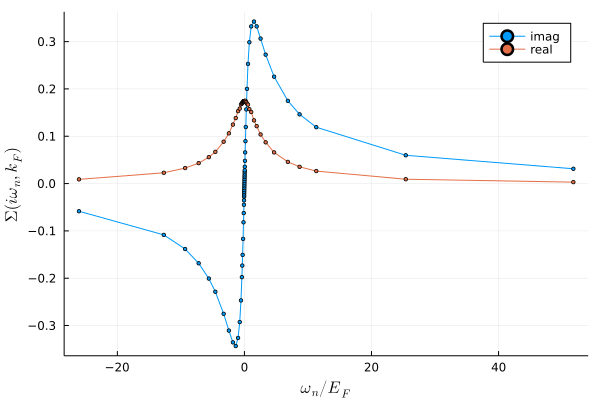

In [66]:
plot(dlr.ωn/para.EF, imag(sigma_wn.dynamic[1, 1, kFidx, :]),marker=2, label="imag", xlabel=L"$\omega_n/E_F$", ylabel=L"$\Sigma(i\omega_n, k_F)$")
plot!(dlr.ωn/para.EF, real(sigma_wn.dynamic[1, 1, kFidx, :]),marker=2, label="real")

### 1.2 Momentum-dependent Self-energy (instant + dynamic)

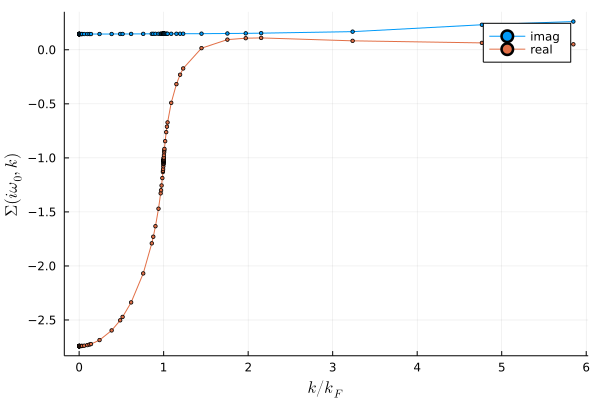

In [67]:
widx = searchsortedfirst(dlr.n, 0)
sig = sigma_wn.dynamic[1, 1, :, widx].+sigma_wn.instant[1, 1, :]
plot(kgrid.grid/para.kF, imag(sig), marker=2, label="imag", xlabel=L"$k/k_F$", ylabel=L"$\Sigma(i\omega_0, k)$")
plot!(kgrid.grid/para.kF, real(sig), marker=2, label="real")

### 1.3 Z-factor and Effective mass

Quasiparticle effective mass can be extracted from the quasiparticle propagator,
$$G(k, i\omega)=\frac{-1}{i\omega-k^2/{2m}+\mu+\Sigma(k, i\omega)}$$
Near the Fermi surface, 
$$Re\Sigma(k, i\omega)=Re\Sigma(k_F, 0)+\frac{\partial Re\Sigma(k_F, 0)}{\partial k} (k-k_F) + ...$$
and,
$$Im\Sigma(k, i\omega)=Im\Sigma(k_F, 0^+)\cdot \text{sgn}(\omega)+\frac{\partial Im\Sigma(k_F, 0^+)}{\partial \omega}\cdot \omega  + ...$$
so that the quasiparticle propagator is renormalized to the form,
$$G(k, i\omega) = \frac{-z}{i\omega-v_F^*(k-k_F)+i\eta \cdot \text{sgn}(\omega)}$$
the wave-function renormalization factor,
$$z=\frac{1}{1+\frac{\partial Im\Sigma(k_F, 0^+)}{\partial \omega}}=\lim_{T\rightarrow 0} \frac{1}{1+\frac{\Sigma(i\omega_2, k_F)-\Sigma(i\omega_1, k_F)}{i2\pi T}}$$
and the quasiparticle life time,
$$\eta = z\cdot Im\Sigma(k_F, 0^+)$$
and the effective mass,
$$\frac{m}{m^*}=z \cdot \left(1-\frac{m}{k_F}\frac{\partial Re\Sigma(k_F, 0)}{\partial k}\right)$$

rs = 1 has Z factor = 0.8582401040786433


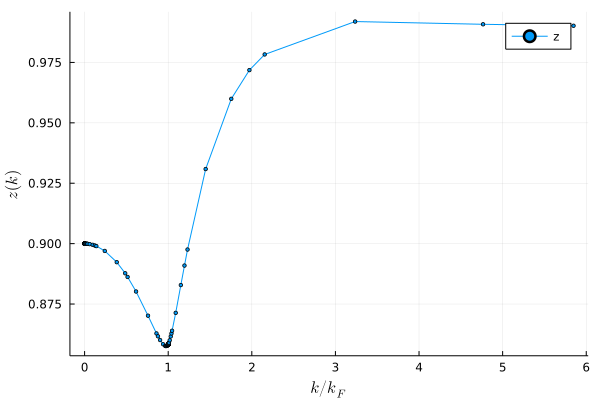

In [84]:
w0idx = searchsortedfirst(dlr.n, 0)
zfactor_wn = @. 1 / (1 + imag(sigma_wn.dynamic[1, 1, :, w0idx+1]-sigma_wn.dynamic[1, 1, :, w0idx]) / (2π) * para.β)
zfactor = zfactor_wn[kFidx]
println("rs = 1 has Z factor = ", zfactor)
plot(kgrid.grid/para.kF, zfactor_wn,marker=2, label="z", xlabel=L"$k/k_F$", ylabel=L"$z(k)$")

In [124]:
zfactor = []
mass = []
rslist = [0.5, 1.0, 2.0,  4.0,  6.0, 8.0]
for _rs in rslist
    param = Parameter.rydbergUnit(1.0/beta, _rs, d)
    @unpack me, β, kF = param
    sigma = SelfEnergy.G0W0(param, minK = 1e-6, Nk=16, order=4);
    sigma_wn = GreenFunc.toMatFreq(sigma);
    dlr = sigma_wn.dlrGrid
    kgrid = sigma_wn.spaceGrid
    kFidx = searchsortedfirst(kgrid.grid, kF)
    #println(kgrid.grid[kFidx]-kF)
    w0idx = searchsortedfirst(dlr.n, 0)
    z = 1 / (1 + imag(sigma_wn.dynamic[1, 1, kFidx, w0idx+1]-sigma_wn.dynamic[1, 1, kFidx, w0idx]) / (2π) * β)
    
    #println("rs = $_rs => $z")
    k1, k2 = kFidx, kFidx+3
    sigma1=real(sigma_wn.dynamic[1, 1, k1, w0idx])+sigma_wn.instant[1, 1, k1]
    sigma2=real(sigma_wn.dynamic[1, 1, k2, w0idx])+sigma_wn.instant[1, 1, k2]
    ds_dk = (sigma1-sigma2)/(kgrid.grid[k1]-kgrid.grid[k2])
    mratio = 1.0/z/(1-me/kF*ds_dk)
    println("rs = $_rs => $z, with m*/m = $mratio")
    push!(zfactor, z)
    push!(mass, mratio)
end

3.806023363139843e-8
rs = 0.5 => 0.9221562238330299, with m*/m = -9.178170640272613 + 0.020285914598148904im
3.806023385344304e-8
rs = 1.0 => 0.8582810830063999, with m*/m = -0.9096074308395263 + 0.0003403250501287528im
3.806023385344304e-8
rs = 2.0 => 0.7573966724945971, with m*/m = -0.3627454234350238 + 9.456023521748499e-5im
3.8060233742420735e-8
rs = 4.0 => 0.6170751724740753, with m*/m = -0.19290759991692863 + 3.47081983790841e-5im
3.8060233742420735e-8
rs = 6.0 => 0.5206794650324887, with m*/m = -0.14563495245168154 + 2.395111228072827e-5im
3.806023377017631e-8
rs = 8.0 => 0.4487272180042192, with m*/m = -0.1238775366656236 + 2.1592204797798402e-5im


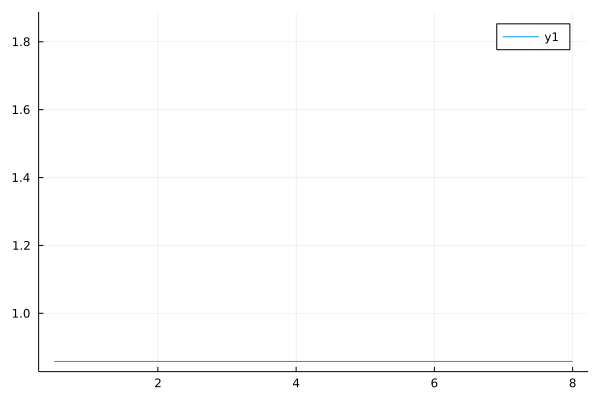

In [92]:
plot(rslist, zfactor)

In [99]:
para

ElectronGas.Parameter.Para
  WID: Int64 1
  dim: Int64 3
  spin: Int64 2
  ϵ0: Float64 0.07957747154594767
  e0: Float64 1.4142135623730951
  me: Float64 0.5
  EF: Float64 3.683168552352866
  β: Float64 271.50535898260324
  μ: Float64 3.683168552352866
  Λs: Float64 0.0
  Λa: Float64 0.0
  espin: Float64 0.0
  beta: Float64 1000.0
  Θ: Float64 0.001
  T: Float64 0.0036831685523528663
  n: Float64 0.23873241463784295
  Rs: Float64 1.0
  a0: Float64 0.9999999999999998
  rs: Float64 1.0000000000000002
  kF: Float64 1.9191582926775128
  e0s: Float64 1.4142135623730951
  e0a: Float64 0.0


In [100]:
Parameter.derive(para, rs=0.5)

ElectronGas.Parameter.Para
  WID: Int64 1
  dim: Int64 3
  spin: Int64 2
  ϵ0: Float64 0.07957747154594767
  e0: Float64 1.4142135623730951
  me: Float64 0.5
  EF: Float64 3.683168552352866
  β: Float64 271.50535898260324
  μ: Float64 3.683168552352866
  Λs: Float64 0.0
  Λa: Float64 0.0
  espin: Float64 0.0
  beta: Float64 1000.0
  Θ: Float64 0.001
  T: Float64 0.0036831685523528663
  n: Float64 0.23873241463784295
  Rs: Float64 1.0
  a0: Float64 0.9999999999999998
  rs: Float64 1.0000000000000002
  kF: Float64 1.9191582926775128
  e0s: Float64 1.4142135623730951
  e0a: Float64 0.0
